<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Explaining_and_Harnessing_Adversarial_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explaining and Harnessing Adversarial Examples**

논문 링크: https://arxiv.org/abs/1412.6572

해당 논문은 GAN의 저자로 유명한 Ian J. Goodfellow님께서 발표하셨다. 물론 해당 논문의 내용은 GAN과 관련이 없다.

DNN을 포함한 몇몇의 ML은 기술의 발달로 인해 Computet Vision과 같이 이미지 분류 등의 기술은 이미 인간을 뛰어넘었다. 하지만 이들은 adversarial examples를 잘못 분류한다. 여기서 **adversarial example이란, 작지만 의도적으로 perturbations(즉, 노이즈)를 데이터에 적용하여 사람의 눈에는 차이가 없어 보이나 모델의 경우는 높은 확률로 오답을 출력하게 하는 것**이다.

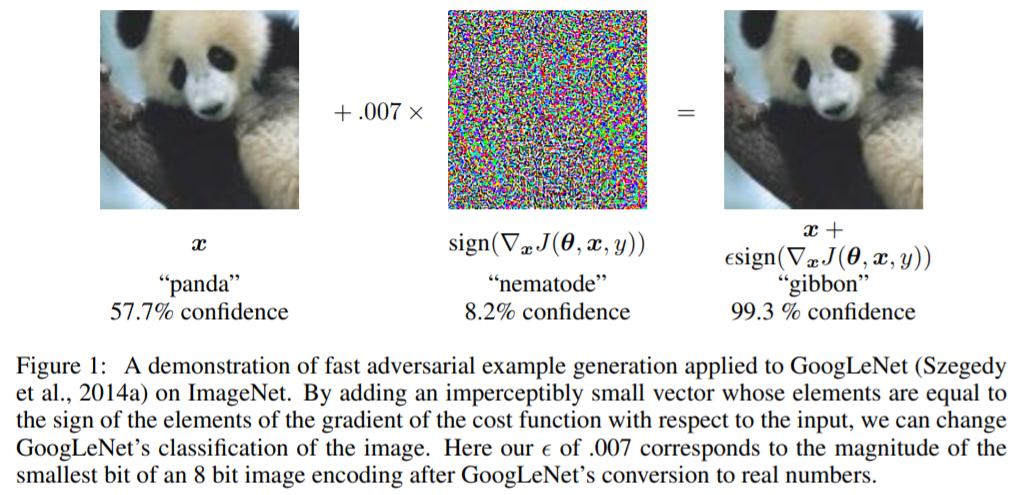

위의 그림 Figure 1을 보면 위에서 한 말을 쉽게 이해할 수 있다. 판다 이미지인 x에 약간의 noise를 추가한 그림이 오른쪽 그림이다. 오른쪽 그림은 사람의 입장에서는 "panda"라고 분류할 수 있지만, 위의 GoogLeNet의 경우는 "gibbon"이라고 분류를 하였다.

이러한 adversarial examples(현재는 trainsfer이 가능하다는 이유로 **trainsferability**라는 이름으로 불린다.)의 원인은 미스테리였으며, **추측에 의하면 DNN의 non-linear과 불충분한 regularization로 인한 overfitting이 원인**이라고 했다. 그러나 고차원 공간에서 선형성은 adversarial examples를 유발했다. 따라서 비선형성이 adversarial의 원인이 아닌 것이다. 본 논문에서는 신경망이 adversarial perturbation에 저항하기에는 매우 linear하다고 가정한다. LSTM, ReLU, maxout networks는 모두 optimizing하기 쉽도록 매우 linear한 방법으로 작동되도록 설계됬다. 즉, **NN은 생각보다 non-linear하지 않으며, 오히려 이런 문제들은 linearity 때문에 adversarial 문제가 발생한다.** 본 논문에서는 모델의 Linear한 점을 이용해 **FGSM**이라는 공격 기법을 제안하며, 이를 방어하며 추가적으로 dropout이나 pretraining과 같이 regularization 효과가 있는 **Adversarial train** 기법을 제안한다. 다만, adversarial train같은 경우는 시간이 더 소비가 되며 expensive하다는 점이 있다.

## **Why Linear?**

최신의 모델들을 보면 ReLU와 같은 굉장히 linearity한 특성을 가진 기법을 적용시킴으로써 train을 쉽게 진행한다. 본 논문에서는 이렇게 linear한 점이 adversarial example를 야기한다고 한다.  기존의 non-linear한 RBF networks의 경우 adversarial examples에 강하다는 점도 이를 뒷받침해준다.

하지만 sigmoid와 같은 함수는 piece-wise linear한 ReLU와 달리 non-linear하지 않냐는 의문이 생길 수 있다.

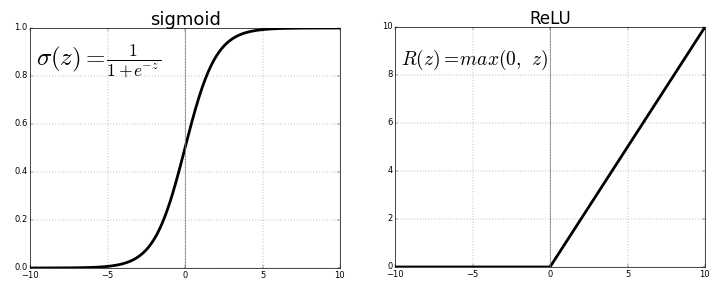

먼저, saturating과 non-saturating의 개념을 이해할 필요가 있다. ReLU의 경우 z값이 무한으로 가면 output값도 무한으로 간다. 반면 sigmoid의 경우 값이 0 ~ 1로 제한되어 있는데 이 점을 보고 saturating하다고 표현한다. 하지만 sigmoid도 가운데 부분을 보면 non-saturating한 부분이 있는데 이 부분에서 상당한 시가을 할애하게 되고 덕분에 모델이 상대적으로 빠르게 수렴하게 된다. 이 때문에 sigmoid의 경우에도 ReLU와 같이 상당히 linear한 특징을 가지고 있다 볼 수있다.

## **FGSM(fast gradient sign method)**

기존의 Szegedy의 L-BFGS는 본 논문에서 제시한 FGSM보다 시간이 오래 걸려 상당히 비효율적이다.

(L-BFGS 논문 링크: https://arxiv.org/abs/1312.6199)

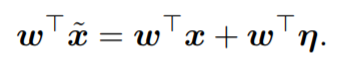

원본 이미지 x에 약간의 노이즈인 η를 추가하는 식은 x~ = x + η와 같이 표현할 수 있다. 이때 η(perturbation)가 매우 작을 경우 분류기 모델은 x와 x~를 같은 class로 구분할 수 있다. 

즉, adversarial example의 output 값이 위의 식과 같이 표현이 될 수 있다. 쉽게 설명하자면, MNIST의 경우 28 x 28이 784의 vector로 들어가게 된다. 이때 weight vector w와 an adversarial example x~사이의 dot product를 위의 식과 같이 정의하여 각 vector의 값마다 +ε를 한것이라고 생각하면 된다. 

그러면 이제 이렇게 w^T x~값을 최대한 증가시킬려면 어떻게 해야할까?

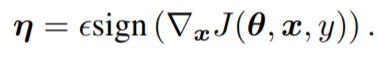

(위의 식에서 θ는 모델의 parameter이고, x는 input이며, y는 input 이미지인 x의 target class이다. 그리고 J(θ, x, y)가 바로 cost function, 즉 loss function이다.)

이에 대한 답은 매우 간단하다. η에 sign(w)값을 넣어주면 된다. η에 위의 식과 같은 조건이 붙는데, 위의 식과 같이 **max norm constraint에 따라 η=sign(w)으로 이 증가를 최대화**시키는 것이다. 이런 조건이 붙는 이유는 Adversarial Attack이 성공하기 위해서는 모델은 완전히 다르게 반응하나 육안(혹은 관측 센서)으로 봤을 때는 별로 차이가 없을 정도로만 이미지가 달라져야하기 때문이다. 따라서 loss function인 J(θ, x, y)를 증가시키는 방향으로 ε만큼 증가시켜 임계값을 넘지 않으면서도 모델에 영향을 주는 η을 위의 식과 같이 구하는 것이다. 즉, **높은 차원에서 input에 아주 작은 noise를 추가하여 Decision boundary를 크게 넘길 수 있다.**

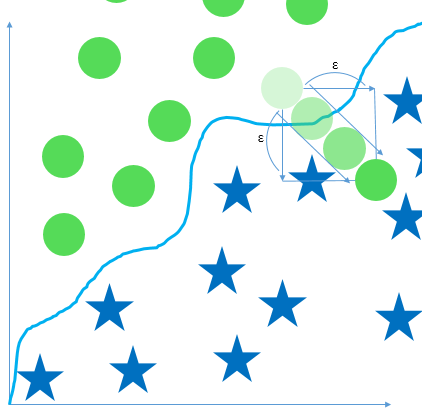

이해를 돕기 위해 위의 그림을 만들어 가져왔다. 즉 차원마다 ε만큼 증가를 하는 것이다.

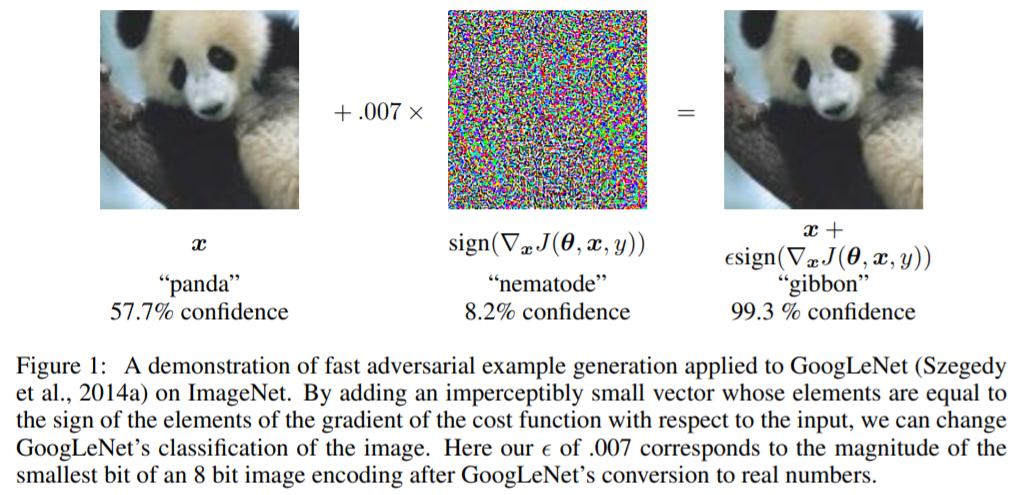

위에서 봤던 이 그림 Figure 1이 바로 ImageNet으로 학습된 GoogLeNet에 FGSM을 적용시킨 것이다. 여기서 ε는 0.007으로 매우 작은 값임에도 불구하고 저런 결과를 도출해냈다.

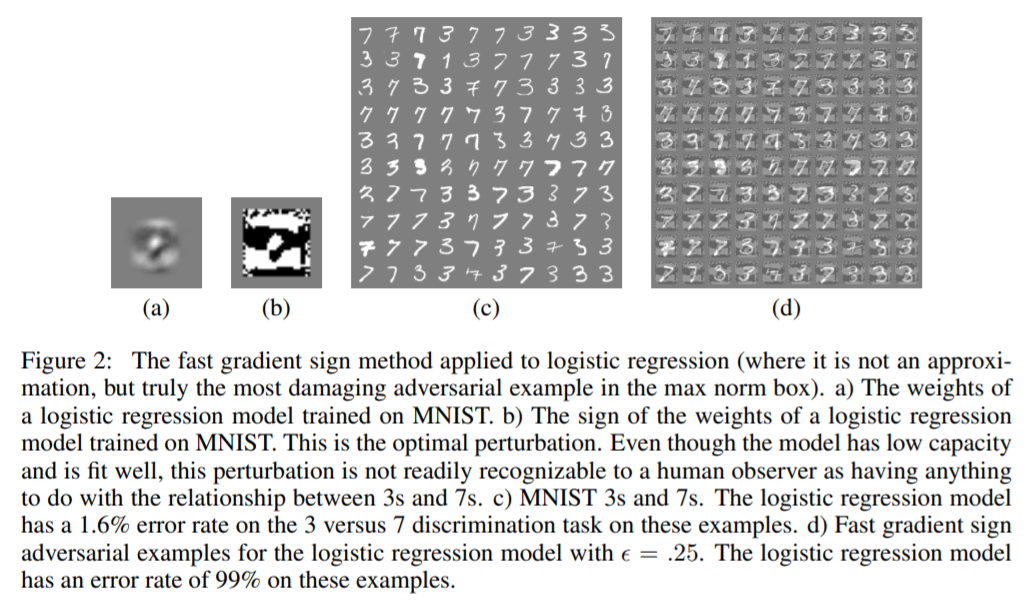

위의 그림 Figure 2는 FGSM을 logistic regression에 적용한 것이다. (a)는 MNIST로 학습된 logistic regression model의 weight이다. (b)는 MNIST로 학습된 모델의 weight의 부호이다. 이것이 바로 최적의 pertubation이다. 그리고 (c)에서는 3과 7이 logistic model에 대해 1.6% error를 가지는 것을 보여준다. (d)에서는 ε = 0.25일때, 무려 99%의 error을 가진다.

### **Pytorch**

In [ ]:
# load model
net = load_model(model_weight_path)
net.eval()

# FSGM을 적용할 이미지 불러오기
img_tensor, label = test_loader.dataset[30]

# batch 차원이 있는 tensor로 변환
img_batch = img_tensor.unsqueeze(0)
label_batch = torch.LongTensor([label])

# input 이미지의 gradient를 구해야 하므로 requires_grad = True
img_batch.requires_grad = True

logits = net(img_batch)
probs = F.softmax(logits, dim=1)[0]

cost_fn = nn.CrossEntropyLoss()
cost = cost_fn(logits, label_batch)
cost.backward()

# cost function에 대한 원본 이미지의 gradient를 구하기
# batch 차원 제거
grad = img_batch.grad.detach()[0]
# 부호만 살리기
signed_grad = torch.sign(grad)
epsilon = .1
eta = epsilon * signed_grad

# 원본 이미지에 perturbation을 가해 Adversarial Example을 만들기
img_hat_tensor = img_tensor + eta

## **ADVERSARIAL TRAINING**

adversarial training은 이름 그대로 adversarial example을 train에 사용하여 학습을 시킨다는 것이다. 본 논문에서는 logistic regression에 적용을 시켰다.

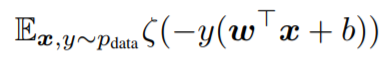

single 모델을 train한다고 했을때 label인 y는 -1 or 1이다. 위의 식이 바로 loss function이고 식에서 ζ는 softplus function이다.

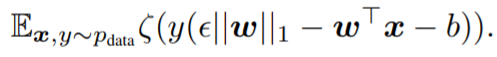

그리고 sign of gradient는 −w x sign(w)이다. (논문에서는 −sign(w)라고 나와있는데 오타인지 잘 모르겠다.) 위의 식에서 x 대신 x - y * sign(w)가 들어간다.

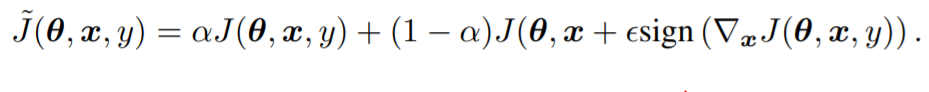

위의 loss가 최종적인 loss function이 된다.

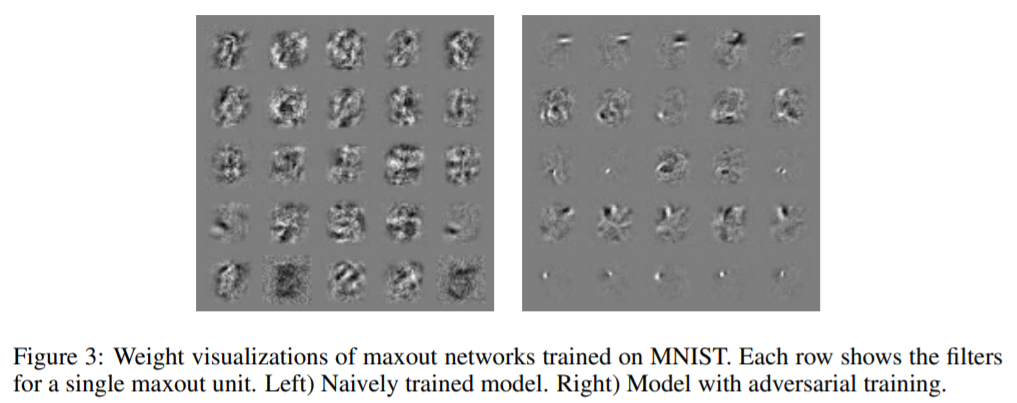

위의 그림 Figure 3은 adversarial train의 효과를 보여준다. 오른쪽 그림은 adversarial training을 한 것이고, 왼쪽은 그냥 train을 한 것이다. 오른쪽 그림을 보면 알 수 있듯이 feature들이 보다 localized된 것을 볼 수 있다. 실제로 adversarial example에 대해 그냥 train한 모델의 error는 89.4%이며 adversarial train을 한 모델의 error 17.9%로 대폭 줄어든 것을 알 수 있다. 하지만 아직 error이 높다는 점은 앞으로 풀어나가야할 문제라고 하였다.